# Lab 03
## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv


%matplotlib inline

## Dataset
Create a dataset from the MFCC of wav files

In [2]:
import glob
import os

PATH = './vowels'

nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

In [3]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav

naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]
nk_audios = [wav.read(path) for path in nk_paths]

naf_mfcc_median = np.array([
   np.median(mfcc(sample, samplerate=sample_rate, nfft=1024), axis=0)
   for sample_rate, sample in naf_audios
])

nam_mfcc_median = np.array([
   np.median(mfcc(sample, samplerate=sample_rate, nfft=1024), axis=0)
   for sample_rate, sample in nam_audios
])

nk_mfcc_median = np.array([
   np.median(mfcc(sample, samplerate=sample_rate, nfft=1024), axis=0)
   for sample_rate, sample in nk_audios
])

In [4]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(copy=False, feature_range=(-1,1))

In [5]:
def plot_confusion_matrix(conf_matrix, classes_names):
    fig, ax = pl.subplots()
    im = ax.imshow(conf_matrix, cmap="viridis")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(classes_names)), labels=classes_names)
    ax.set_yticks(np.arange(len(classes_names)), labels=classes_names)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(classes_names)):
        for j in range(len(classes_names)):
            text = ax.text(j, i, conf_matrix[i, j], fontweight="bold", fontsize="large", ha="center", va="center", c="r")

    fig.tight_layout()
    pl.show()

In [64]:
def get_f1_score_for_class (conf_matrice, number, nb_classes = 2):
   TP = conf_mat[number, number]
   TN = sum([ conf_mat[i][i] for i in range(nb_classes) if i != number ])
   FP = sum([ conf_mat[number][i] for i in range(nb_classes) if i != number ])
   FN = sum([ conf_mat[i][number] for i in range(nb_classes) if i != number ])

   precision = TP / (TP + FP)
   recall    = TP / (TP + FN)
   f1_score  = 2 * precision * recall / (precision + recall)
   return f1_score

# Experiment 2 - Man vs Woman vs Child

In [6]:
nk_mfcc_median = nk_mfcc_median[::3]
mfccs = np.concatenate((naf_mfcc_median, nam_mfcc_median, nk_mfcc_median))
min_max_scaler.fit(mfccs)
mfccs = min_max_scaler.transform(mfccs)
classes = np.concatenate((
   np.full((naf_mfcc_median.shape[0], 3), (1, 0, 0)),
   np.full((nam_mfcc_median.shape[0], 3), (0, 1, 0)),
   np.full((nk_mfcc_median.shape[0], 3), (0, 0, 1))
))
dataset = np.column_stack((mfccs, classes))
dataset.shape

(108, 16)

## Exploring the number of hidden neurons

In [10]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.003
MOMENTUM = 0.9

In [11]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
   print('Testing', h, 'neurons...')
   nn = mlp.MLP([13,h,3], 'tanh')
   for i in np.arange(N_INITS):                                        # looping over the initializations
      nn.init_weights()
      
      MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:16]),
                              learning_rate=LEARNING_RATE,
                              momentum=MOMENTUM,
                              epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


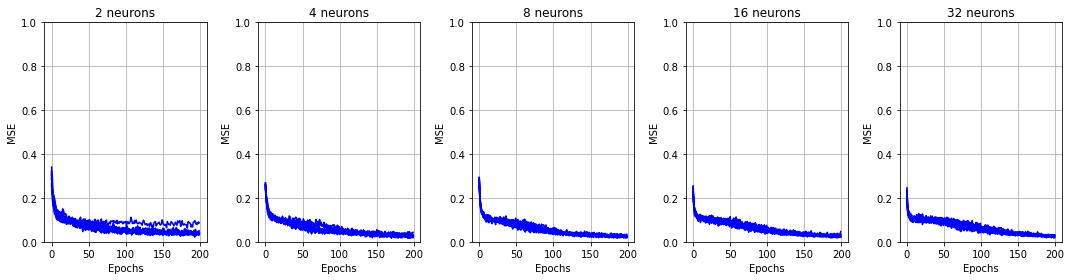

In [12]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

## Exploring the number of hidden neurons

In [17]:
EPOCHS = 200
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8]

In [18]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,3], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...


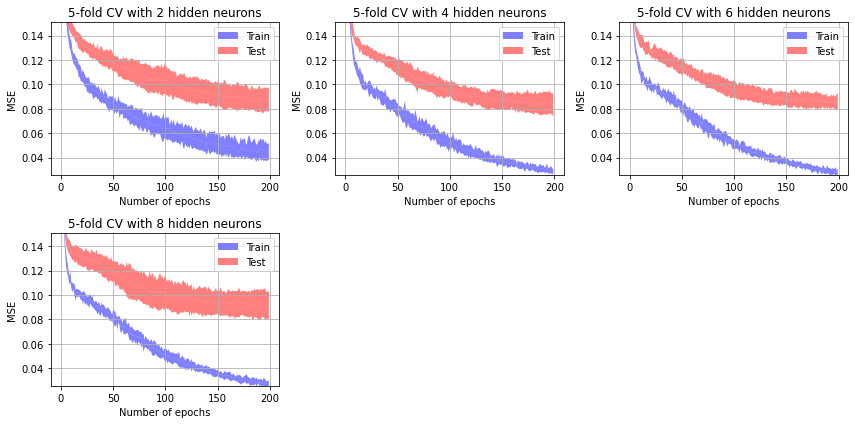

In [19]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

## The final model
An artificial neural network with 4 neurons and 50 iterations of the backpropagation algorithm is enough to solve the problem.

In [ ]:
nn = mlp.MLP([13,4,3], 'tanh')

In [55]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=130,
                                                          threshold=0.6)

MSE training:  0.0411144210156736
MSE test:  0.10130067646660372
Confusion matrix:


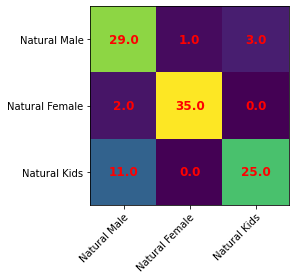

(108, 16)
F1 score natural male : 0.7733
F1 score natural female : 0.9589
F1 score natural kids : 0.7812

Weighted average f1 score : 0.8152


In [65]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
plot_confusion_matrix(conf_mat, ['Natural Male', 'Natural Female', 'Natural Kids'])
print(dataset.shape)

# F1 Score Natural Male
males_f1 = get_f1_score_for_class(conf_mat, 0, 3)
print(f"F1 score natural male : {round(males_f1, 4)}")

# F1 Score Natural Female
females_f1 = get_f1_score_for_class(conf_mat, 1, 3)
print(f"F1 score natural female : {round(females_f1, 4)}")

# F1 Score Natural Kids
kids_f1 = get_f1_score_for_class(conf_mat, 2, 3)
print(f"F1 score natural kids : {round(kids_f1, 4)}")

# Weighted average F1 score
nbMales = len(naf_audios)
nbFemales = len(nam_audios)
nbKids = len(nk_audios)
totalData = nbMales + nbFemales + nbKids
average_f1 = (nbMales * males_f1 + nbFemales * females_f1 + nbKids * kids_f1) / totalData

print(f"\nWeighted average f1 score : {round(average_f1, 4)}")